# Competitive coevolution with GEP

## Regex for test

In [1]:
input_regex = '((a|bb?)|(a|ba?)|([0-9]|.ab))'

params = {
    'range': ['0-9'],
    'repeat': ['0,1'],
}
    
nodes = {
    # functions (except any)
    -1: 'params', 
    0: 'seq', 
    1: 'atom', 
    2: 'any', 
    3: 'repeat', 
    4: 'alt', 
    5: 'altgroup', 
    6: 'group', 
    7: 'range', 
    8: 'escape', 

    # terminals (get by input regex)
    9: 'a', 
    10: 'b',
}

In [2]:
from coevolutionary.utils import Utils
from coevolutionary.utils import regex_process

test_strings = Utils.get_test_strings(
    input_regex=input_regex,
    n_fuzzy_strings=5
)

X, Y = Utils.create_training_set(
    test_strings=test_strings,
    original_regex=input_regex,
    process_func=regex_process,
)  

## Run

In [3]:
from coevolutionary.manager import CompetitiveManager
from coevolutionary.algorithms.gep import GEPAlgorithm
from coevolutionary.utils.terminals import get_terminals

In [4]:
cm = CompetitiveManager(
    adaptive_interval=5,
    shared_resource=10_000,
    verbose=False,
    problem='min',
    survive_schema='best',
    social_card=0.3,
    penalty=0.10,
    seed=123,
)

In [5]:
params_cases = [
    {'population_length': 100, 'genes_n': 5, 'head_n': 3, 'n_elites': 10},
    {'population_length': 100, 'genes_n': 3, 'head_n': 4, 'n_elites': 20},
]

### Run algorithms in coevolution

In [6]:
terminals = get_terminals(
    add_digits=False,
    add_lower_latin_letters=False,
    add_custom_symbols=True,
    custom_symbols=['a', 'b', 'any', 'range', 'escape']
)

for i, case in enumerate(params_cases):
    gep_object = GEPAlgorithm(
        X=X,
        Y=Y,
        n_iter=100,
        terminals=terminals,
        params=params,
    )
    
    cm.add_algorithm(
        name=f'gep_{i}',
        init_params=case,
        init_algorithm=gep_object.init_algorithm,
        init_population=gep_object.init_population,
        get_fitness_population=gep_object.get_fitness_population,
        select_population=gep_object.select_population,
        recombine_population=gep_object.recombine_population,
        mutate_population=gep_object.mutate_population,
    )

In [7]:
cm.run_coevolution()

Done in 17.722 seconds


In [8]:
coevolution_algorithm_history = cm.algorithm_history
population_qualities_history = cm.population_qualities_history
coev_names = cm.get_algorithm_names()

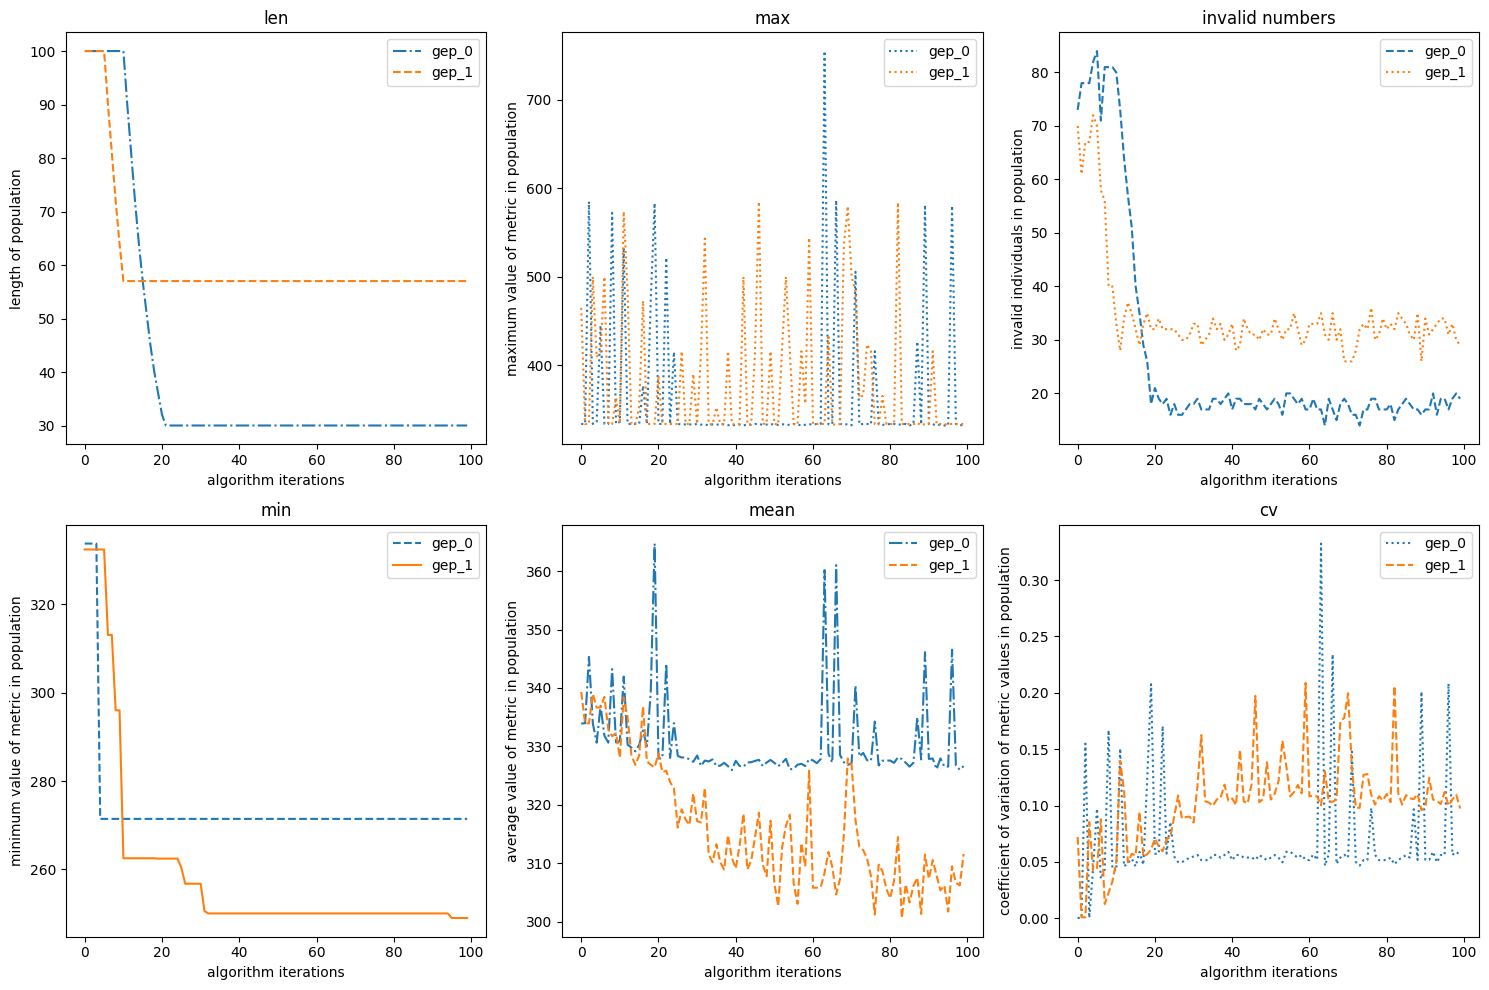

In [9]:
from coevolutionary.utils.visualization import visualize

visualize(
    algorithm_history=coevolution_algorithm_history,
    algorithm_names=coev_names
)

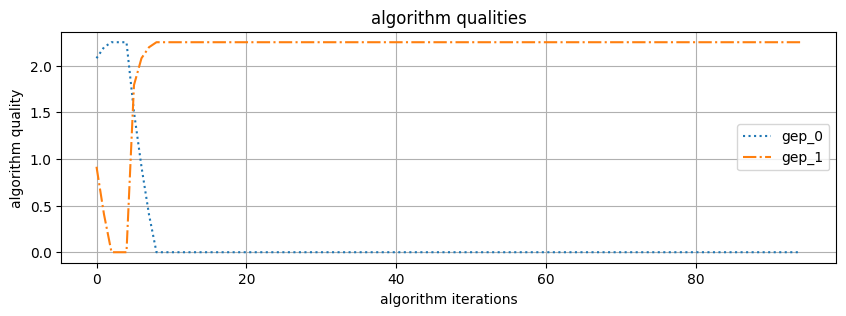

In [10]:
import matplotlib.pyplot as plt
from coevolutionary.utils.visualization import visualize_algorithms_quality

plt.rcParams["figure.figsize"] = (10, 3)
visualize_algorithms_quality(
    population_qualities_history=population_qualities_history,
    algorithm_names=coev_names
)

### Run algorithms separately

In [11]:
separately_algorithm_history = {}
sep_names = []

In [12]:
from coevolutionary.utils.tests import check_wilcoxon

for i, case in enumerate(params_cases):
    cm = CompetitiveManager(
        adaptive_interval=2,
        shared_resource=5_000,
        verbose=False,
        problem='min',
        survive_schema='best',
        social_card=0.3,
        penalty=0.10,
        seed=123,
    )
    
    gep_object = GEPAlgorithm(
        X=X,
        Y=Y,
        n_iter=100,
        terminals=terminals,
        params=params,
    )
    
    cm.add_algorithm(
        name=f'gep_{i}_sep',
        init_params=case,
        init_algorithm=gep_object.init_algorithm,
        init_population=gep_object.init_population,
        get_fitness_population=gep_object.get_fitness_population,
        select_population=gep_object.select_population,
        recombine_population=gep_object.recombine_population,
        mutate_population=gep_object.mutate_population,
    )
    
    # overload run
    cm.run_coevolution()
    
    separately_algorithm_history[i] = cm.algorithm_history[0]
    sep_names.append(f'gep_{i}_sep')
    
    check_wilcoxon(
        history_a=cm.algorithm_history,
        history_b=coevolution_algorithm_history,
        a_name=f'gep_{i}_sep',
        b_name=f'gep_{i}',
        a_index=0,
        b_index=i,
        metric_number=1,
        metric_name='minimum'
    )

Done in 5.427 seconds
The Wilcoxon test for minimum metric
✓ According to the Wilcoxon test gep_0_sep and gep_0 are different

Done in 7.56 seconds
The Wilcoxon test for minimum metric
✓ According to the Wilcoxon test gep_1_sep and gep_1 are different



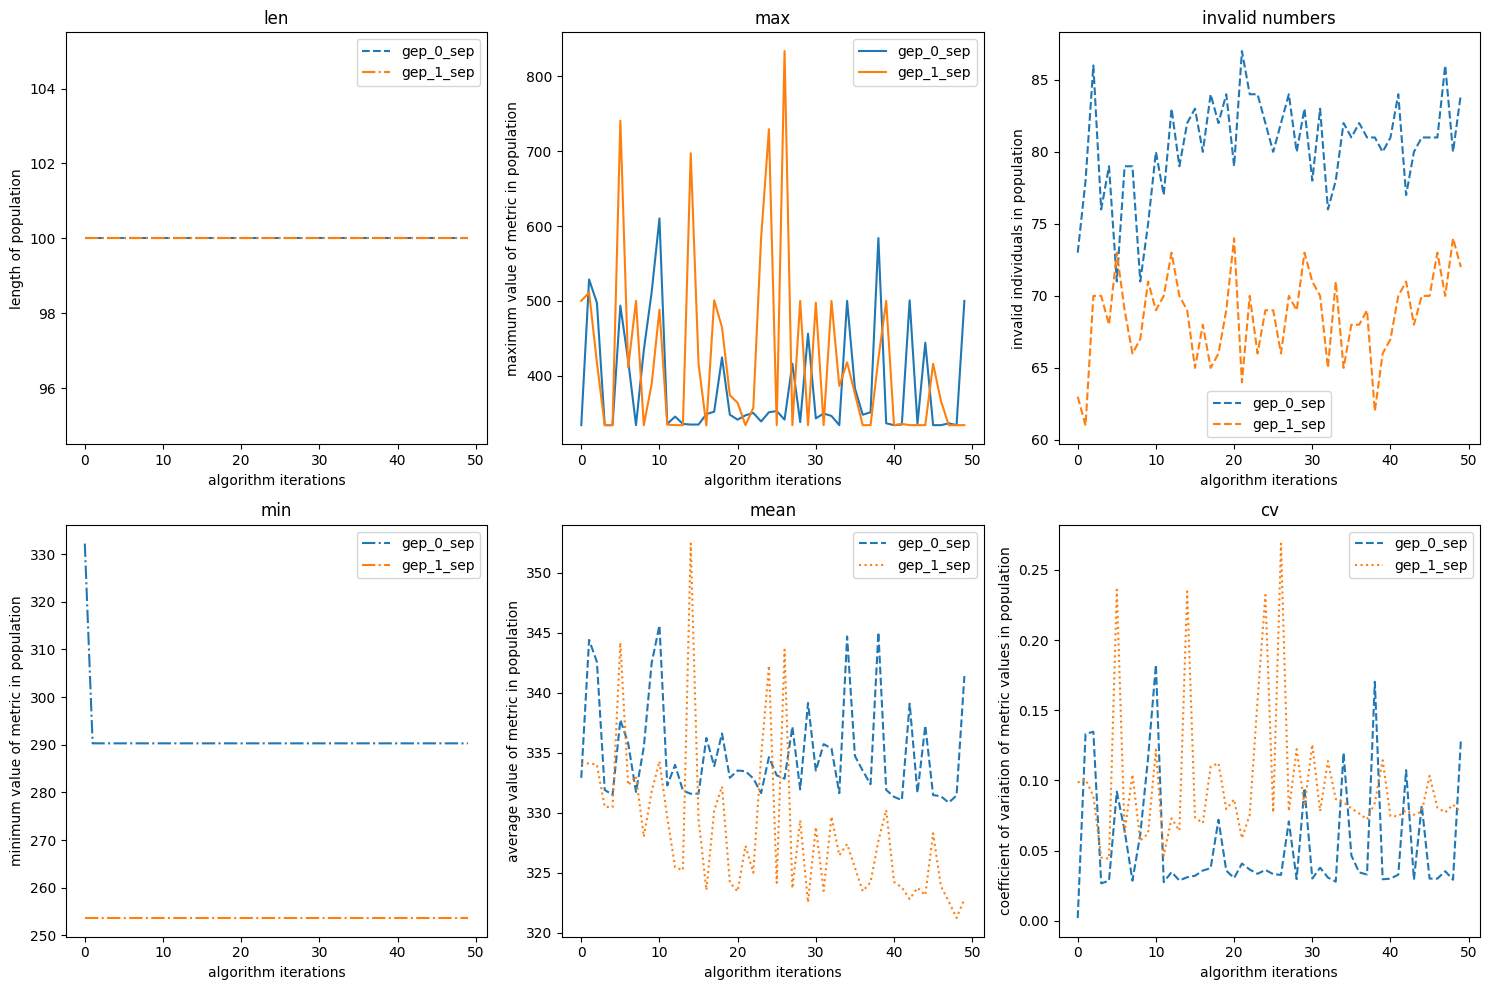

In [13]:
from coevolutionary.utils.visualization import visualize

plt.rcParams["figure.figsize"] = (15, 10)
visualize(
    algorithm_history=separately_algorithm_history,
    algorithm_names=sep_names
)